<a href="https://colab.research.google.com/github/Farfaoua01/DL_Project/blob/main/projetDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

In [3]:
data_dir = '/content/drive/MyDrive/brain_tumor_dataset'

categories = ['yes', 'no']
print(os.listdir(data_dir))

['yes', 'no']


# Nouvelle section

In [50]:
for category in categories:
    path = os.path.join(data_dir, category)
    print(f"{category}: {len(os.listdir(path))} images")


yes: 155 images
no: 98 images


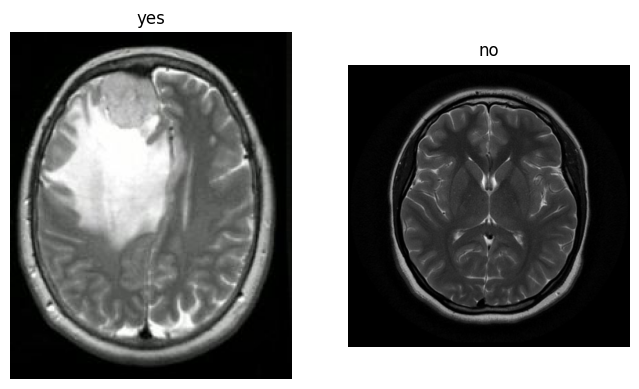

In [51]:
plt.figure(figsize=(8, 8))
for i, category in enumerate(categories):
    path = os.path.join(data_dir, category)
    img_path = os.path.join(path, os.listdir(path)[0])
    img = load_img(img_path)
    plt.subplot(1, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')
plt.show()


In [52]:
#nettoyage des donnees
corrupted_count = 0

for category in categories:
    path = os.path.join(data_dir, category)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        try:
            img = load_img(img_path)
        except Exception as e:
            print(f"Erreur avec {img_name}: {e}")
            corrupted_count += 1

if corrupted_count == 0:
    print("Toutes les images ont été chargées correctement. Aucun fichier vide ou corrompu trouvé")
else:
    print(f"Nombre d'images corrompues ou illisibles : {corrupted_count}")

Toutes les images ont été chargées correctement. Aucun fichier vide ou corrompu trouvé


{'yes': 155, 'no': 98}


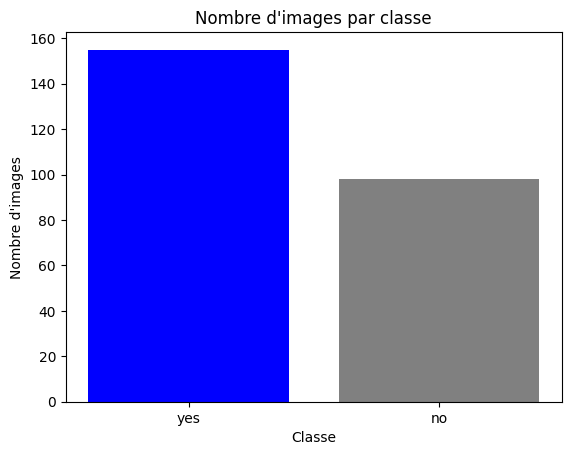

In [53]:
counts = {}
for category in categories:
    path = os.path.join(data_dir, category)
    counts[category] = len(os.listdir(path))

print(counts)
plt.bar(counts.keys(), counts.values(), color=['blue', 'gray'])
plt.title("Nombre d'images par classe")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.show()


In [54]:
yes_dir = os.path.join(data_dir, 'yes')
no_dir  = os.path.join(data_dir, 'no')

yes_count = len(os.listdir(yes_dir))
no_count = len(os.listdir(no_dir))

print("Yes :", yes_count)
print("No  :", no_count)

# Combien d'images faut-il ajouter ?
nb_to_generate = yes_count - no_count
print("Images à générer pour équilibrer :", nb_to_generate)

# Si no > yes on ne génère rien
if nb_to_generate <= 0:
    print("Aucune augmentation nécessaire.")
else:
    datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=(0.8, 1.2),
    )

    generated = 0

    for img_name in os.listdir(no_dir):
        if generated >= nb_to_generate:
            break

        img_path = os.path.join(no_dir, img_name)
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Générer 1 image augmentée par image
        for batch in datagen.flow(
            x,
            batch_size=1,
            save_to_dir=no_dir,
            save_prefix='aug_no',
            save_format='jpg'
        ):
            generated += 1
            break  # On s'arrête à 1 image générée

    print("Augmentation terminée. Images générées :", generated)


Yes : 155
No  : 98
Images à générer pour équilibrer : 57
Augmentation terminée. Images générées : 57


In [55]:
counts_after = {}
for category in categories:
    path = os.path.join(data_dir, category)
    counts_after[category] = len(os.listdir(path))

print("Nouveaux nombres :", counts_after)


Nouveaux nombres : {'yes': 155, 'no': 155}


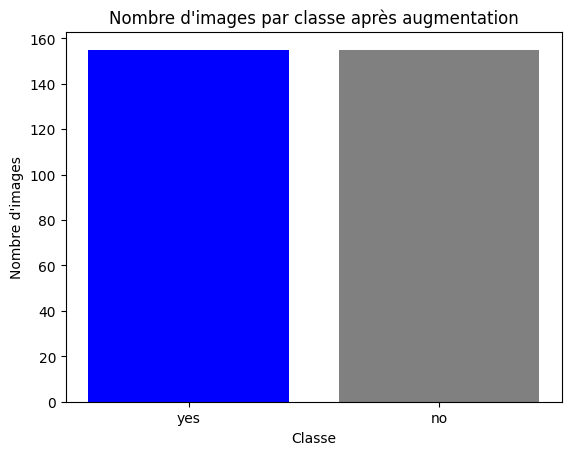

In [56]:
plt.bar(counts_after.keys(), counts_after.values(), color=['blue', 'gray'])
plt.title("Nombre d'images par classe après augmentation")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.show()



In [58]:
# Nombre d'images augmentées par image originale
num_aug_per_image = 2  # tu peux mettre 3, 5, 10, 20…

datagen = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.3,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    brightness_range=(0.7, 1.3),
)

for category in categories:
    print(f"Augmentation pour la classe : {category}")

    folder = os.path.join(data_dir, category)
    images = os.listdir(folder)

    for img_name in images:
        img_path = os.path.join(folder, img_name)
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Générer `num_aug_per_image` images
        count = 0
        for batch in datagen.flow(
            x,
            batch_size=1,
            save_to_dir=folder,
            save_prefix=f'aug_{category}',
            save_format='jpg'
        ):
            count += 1
            if count >= num_aug_per_image:
                break

print("Augmentation totale terminée ! ")


Augmentation pour la classe : yes
Augmentation pour la classe : no
Augmentation totale terminée ! 


In [59]:
counts_after = {category: len(os.listdir(os.path.join(data_dir, category)))
                for category in categories}

print("Nombres d'images après  :", counts_after)


Nombres d'images après  : {'yes': 462, 'no': 459}


In [11]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


In [12]:

img_size = 224
batch_size = 32

datagen_train = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen_train.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = datagen_train.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 734 images belonging to 2 classes.
Found 182 images belonging to 2 classes.


In [13]:
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size, img_size, 3)
)
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)


In [15]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 959,041 (3.66 MB)

 Non-trainable params: 6,209,792 (23.69 MB)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
]


In [18]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.9120 - loss: 0.2313 - val_accuracy: 0.9231 - val_loss: 0.1798 - learning_rate: 1.0000e-05
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 0.9332 - loss: 0.2086 - val_accuracy: 0.9286 - val_loss: 0.1773 - learning_rate: 1.0000e-05
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.9290 - loss: 0.2049 - val_accuracy: 0.9286 - val_loss: 0.1745 - learning_rate: 1.0000e-05
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.9394 - loss: 0.1745 - val_accuracy: 0.9286 - val_loss: 0.1720 - learning_rate: 1.0000e-05
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.9237 - loss: 0.1827 - val_accuracy: 0.9341 - val_loss: 0.1698 - learning_rate: 1.0000e-05
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.9337 - loss: 0.1789 - val_accuracy: 0.9341 - val_loss: 0.1677 - learning_rate: 1.0000e-05
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 

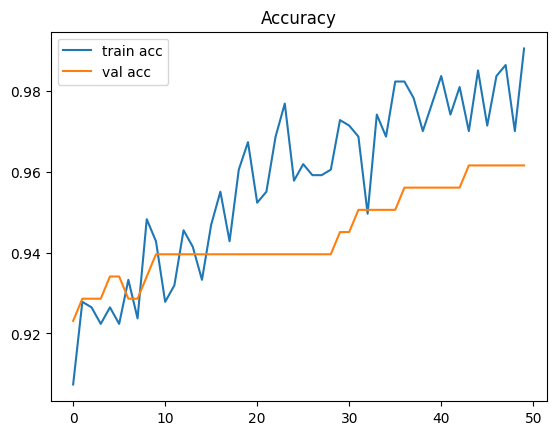

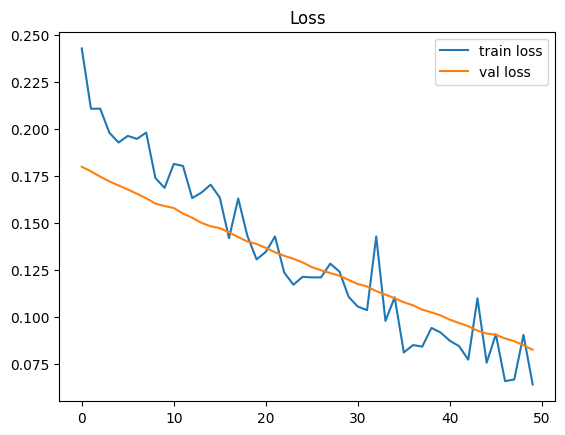

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()


Found 182 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        91
           1       0.98      0.95      0.96        91

    accuracy                           0.96       182
   macro avg       0.96      0.96      0.96       182
weighted avg       0.96      0.96      0.96       182



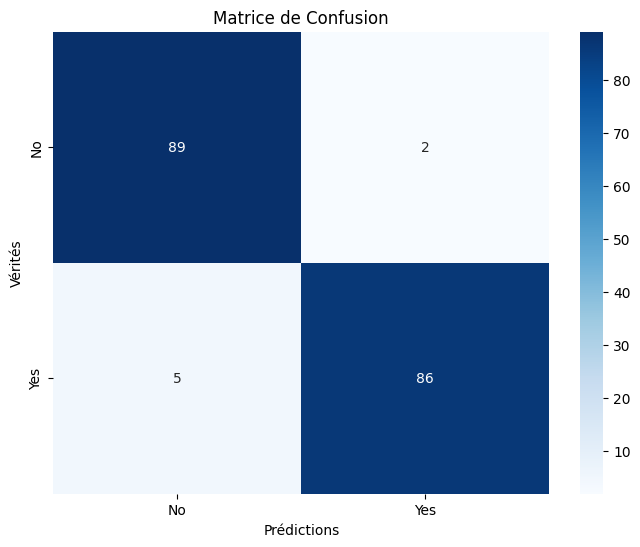

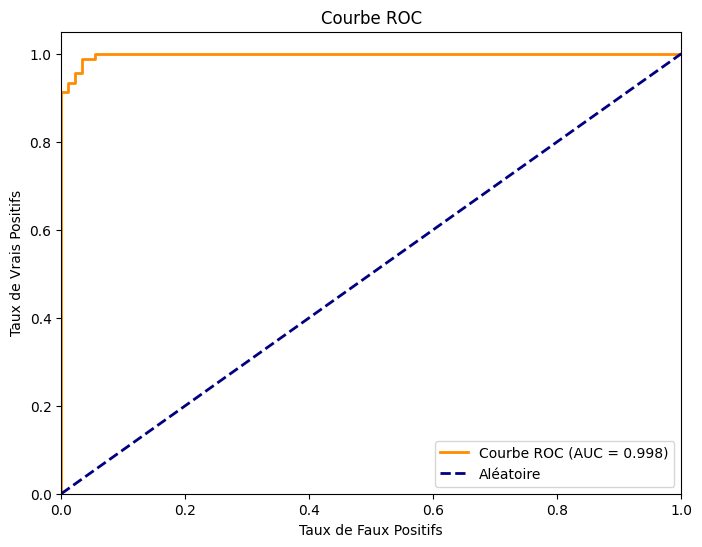

Accuracy: 0.9615384615384616
Precision: 0.9772727272727273
Recall (Sensibilité): 0.945054945054945
Spécificité: 0.978021978021978
F1-Score: 0.9608938547486033
AUC: 0.9975848327496679


In [44]:
# Recréer le générateur de validation avec shuffle=False
val_generator_no_shuffle = datagen_train.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Réinitialiser et prédire
val_generator_no_shuffle.reset()
y_pred = model.predict(val_generator_no_shuffle)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
y_true = val_generator_no_shuffle.classes

# Rapport de classification
print(classification_report(y_true, y_pred_classes))

# Matrice de confusion et courbe ROC
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'])
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de Confusion')
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

# Métriques détaillées
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall (Sensibilité):", recall)
print("Spécificité:", specificity)
print("F1-Score:", f1_score)
print("AUC:", roc_auc)

 TÉLÉCHARGEMENT D'IMAGE
1. Cliquez sur 'Choisir des fichiers'
2. Sélectionnez votre image Y1.jpg
3. Attendez que le téléchargement se termine
4. L'analyse commencera automatiquement


Saving 2 no.jpeg to 2 no.jpeg
Image '2 no.jpeg' téléchargée avec succès!
 Analyse de l'image en cours...

 RÉSULTATS DE LA DÉTECTION
Fichier: 2 no.jpeg
Résultat: NON  (Pas de tumeur)
Probabilité: 0.0395
Confiance: 96.05%


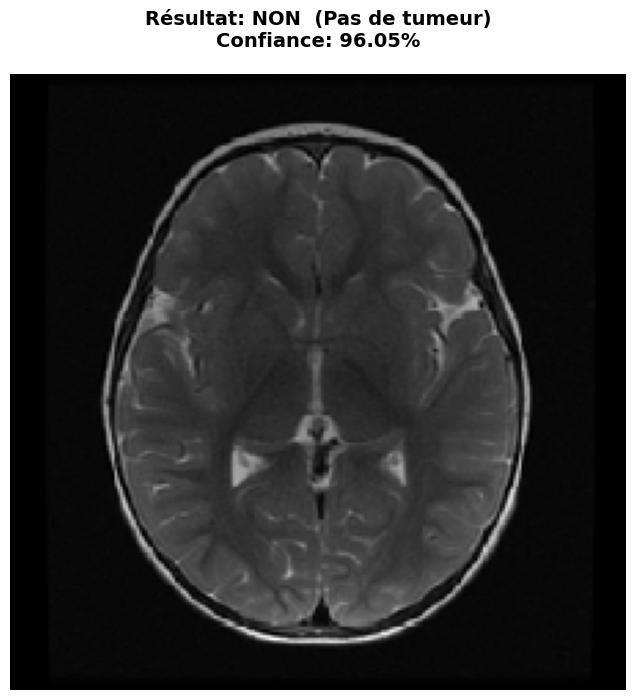

('NON  (Pas de tumeur)', np.float32(0.03949669))

In [47]:
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

def upload_and_test_image():
    """
    Télécharger une image depuis votre ordinateur et la tester
    """
    print(" TÉLÉCHARGEMENT D'IMAGE")
    print("=" * 50)
    print("1. Cliquez sur 'Choisir des fichiers'")
    print("2. Sélectionnez votre image Y1.jpg")
    print("3. Attendez que le téléchargement se termine")
    print("4. L'analyse commencera automatiquement")
    print("=" * 50)

    # Télécharger l'image
    uploaded = files.upload()

    if not uploaded:
        print(" Aucune image téléchargée")
        return

    # Récupérer le nom du fichier téléchargé
    filename = list(uploaded.keys())[0]
    print(f"Image '{filename}' téléchargée avec succès!")

    # Charger et prétraiter l'image
    img = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Faire la prédiction
    print(" Analyse de l'image en cours...")
    prediction = model.predict(img_array, verbose=0)
    probability = prediction[0][0]

    # Interpréter le résultat
    if probability > 0.5:
        classe = "OUI (Tumeur détectée)"
        confidence = probability
    else:
        classe = "NON  (Pas de tumeur)"
        confidence = 1 - probability

    # Afficher les résultats
    print("\n" + "=" * 60)
    print(" RÉSULTATS DE LA DÉTECTION")
    print("=" * 60)
    print(f"Fichier: {filename}")
    print(f"Résultat: {classe}")
    print(f"Probabilité: {probability:.4f}")
    print(f"Confiance: {confidence:.2%}")
    print("=" * 60)

    # Afficher l'image
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Résultat: {classe}\nConfiance: {confidence:.2%}',
             fontsize=14, pad=20, weight='bold')
    plt.show()

    return classe, probability

# LANCER LE TÉLÉCHARGEMENT ET LE TEST
upload_and_test_image()

In [ ]:
model.save("mon_model.h5")


In [ ]:
model.save("mon_model_complet.keras")
